In [1]:
from __future__ import division
from glob import glob
import skimage.feature as ft
from skimage import data, color, exposure
from scipy import misc

import pandas as pd
import numpy as np

from time import time

import matplotlib.pyplot as plt

%matplotlib inline

/home/estevao/py2_kernel/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [3]:
basedir = '../../../BYindex/'

directories=[basedir+"cellsData/ClassAna", 
             basedir+"cellsData/Celulas classificadas - ZeH/Curva de crescimento/0dias/08-07-2016 (Menk)",
             basedir+"cellsData/Celulas classificadas - ZeH/IM/16-09",
             basedir+"cellsData/SC_13-07-2016"]

 
features = pd.DataFrame()
for saveDir in directories:
    allFiles = glob(saveDir+"/*.csv")
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        df["file"] = df.file.apply(lambda x: saveDir +'/'+ x)
        features = pd.concat([features,df],ignore_index=True)
        


In [4]:
print(features.head())
print(features.shape)

                                                file           class
0  ../../../BYindex/cellsData/ClassAna/BY2_5dias ...  unclassifiable
1  ../../../BYindex/cellsData/ClassAna/BY2_5dias ...      not a cell
2  ../../../BYindex/cellsData/ClassAna/BY2_5dias ...       interfase
3  ../../../BYindex/cellsData/ClassAna/BY2_5dias ...       interfase
4  ../../../BYindex/cellsData/ClassAna/BY2_5dias ...       interfase
(2673, 2)


# Preprocessing

In [5]:
for classy in features['class'].unique():
    print('Number of items considered '+str(classy)+':  ' +str(sum(features['class']==classy) ) )

    
print('DELETING UNALLOWED CLASSES\n...\n...\n...')
allowed_classes = ['unclassifiable','not a cell','interfase','mitose']

features = features[features['class'].apply(lambda x: x in allowed_classes)]

for classy in features['class'].unique():
    print('Number of items considered '+str(classy)+':  ' +str(sum(features['class']==classy) ) )


Number of items considered unclassifiable:  52
Number of items considered not a cell:  50
Number of items considered interfase:  1358
Number of items considered unknown:  753
Number of items considered mitose:  456
Number of items considered BY2_5dias (98)i:  1
Number of items considered 15:  1
Number of items considered BY2_5dias (66)i:  1
Number of items considered 28:  1
DELETING UNALLOWED CLASSES
...
...
...
Number of items considered unclassifiable:  52
Number of items considered not a cell:  50
Number of items considered interfase:  1358
Number of items considered mitose:  456


In [6]:
%time features["photo"] = features.file.apply(lambda x: misc.imread(x))
%time features["photo"] = features.photo.apply(lambda x: x[:,:,-1])

CPU times: user 1.22 s, sys: 60 ms, total: 1.28 s
Wall time: 1.28 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.78 ms


In [7]:
features['shape'] = features['photo'].apply(np.shape)
print(np.sum(features['shape']!= (100,100)))
features = features[features['shape']== (100,100)]

1


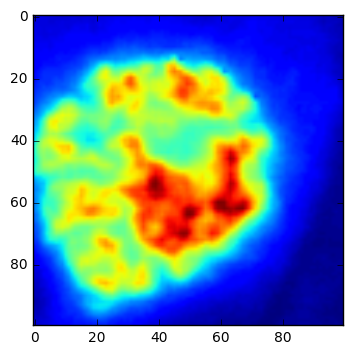

In [8]:
plt.imshow(features.photo[30])

def getHoG(image):
    HOG = ft.hog(image).reshape(1,-1)
    return HOG

def getLBP(image):
    hLBP = np.array([]).reshape(1,-1)
    for P in range(4,20,2):
        for R in range(2,10,2):
            LBP = ft.local_binary_pattern(image, P, R, 'uniform').reshape(-1,1)
            hLBP = np.hstack((np.histogram(LBP,50,range=(0,50))[0].reshape(1,-1), hLBP))

    return hLBP[0]

In [9]:
%time features['HoG'] = features.photo.apply(getHoG)
%time features['LBP'] = features.photo.apply(getLBP)

CPU times: user 4.51 s, sys: 92 ms, total: 4.6 s
Wall time: 4.54 s
CPU times: user 2min 30s, sys: 136 ms, total: 2min 30s
Wall time: 2min 30s


In [10]:
from numpy.fft import fft2
def abs_pha_fft(image):
    imfft = fft2(image)
    return np.hstack([np.abs(imfft).reshape(1,-1), np.angle(imfft).reshape(1,-1)])
features['fft'] = features.photo.apply(abs_pha_fft)

In [11]:
photo_features = features.copy()

phase_classes = ['interfase','mitose']
features = features[features['class'].apply(lambda x: x in phase_classes)]

LE = LabelEncoder()
LE.fit(phase_classes)

LabelEncoder()

In [12]:
def isGoodPhoto(label):
    if label in ['interfase','mitose']: return 1
    else: return 0

photo_features['class'] = photo_features['class'].apply(isGoodPhoto)

# Feature generation

In [15]:
Xhog = np.array(features.HoG.tolist())[:,0,:]
Xlbp = np.array(features.LBP.tolist())[:,:]
FFT = np.array(features.fft.tolist())[:,0,:]


Xfft = np.hstack([FFT,Xhog,Xlbp])

In [13]:
Yphoto = np.array(photo_features['class'].tolist())
Y = np.array(LE.transform(features['class']).tolist())

# Implementation


#### Suvrel

In [159]:
from metriclearning import suvrel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

class Suvrel():
    def __init__(self):
        pass
        
    def fit(self,X,y):
        self.gamma_ = suvrel(X,y)
        
    def transform(self,X,y = None):
        return self.gamma_*X
    
    def fit_transform(self,X,y=None):
        self.fit(X,y)
        return self.transform(X,y)

    def get_params(self,deep=True):
        return {}
    
    def set_params(self):
        return self

#### Scaler/normalization

In [104]:
suv=Suvrel()
suv.fit(Xfft,Y)

In [106]:
Xt = suv.transform(Xfft,Y)

#### Pipeline

In [139]:
classifiers = [
    SVC(),
    LinearSVC(),
    DecisionTreeClassifier(),
    LogisticRegression()
]

In [141]:
suvel_transform = Suvrel()
scaler = StandardScaler()
pca = PCA(n_components=1200)


noScaleResults = []
scaledResults = []
pcaResults = []

for clf in classifiers:
    noScalePipe = Pipeline([('suv', suvel_transform),('classifier',clf)])
    scalePipe = Pipeline([ ('scaler',scaler), ('suv',suvel_transform) ,('classifier',clf)] )
    pcaPipe = Pipeline([ ('scaler',scaler), ('suv',suvel_transform), ('pca', pca),('classifier',clf)] )
    
    noScaleResults.append(cross_val_score(noScalePipe,Xfft,Y,cv=5,scoring='f1') )
    scaledResults.append(cross_val_score(scalePipe,Xfft,Y,cv=5,scoring='f1') )
    pcaResults.append(cross_val_score(pcaPipe,Xfft,Y,cv=5,scoring='f1') )
    
noScaleResults = np.array(noScaleResults)
scaledResults = np.array(scaledResults)
pcaResults = np.array(pcaResults)

In [142]:
print(noScaleResults)
print(noScaleResults.mean(axis=1))
print(noScaleResults.std(axis=1))

[[ 0.62666667  0.35897436  0.40350877  0.40350877  0.38938053]
 [ 0.40350877  0.10416667  0.          0.401766    0.02150538]
 [ 0.70642202  0.65306122  0.53807107  0.61538462  0.62420382]
 [ 0.26388889  0.21238938  0.10416667  0.21935484  0.25503356]]
[ 0.43640782  0.18618936  0.62742855  0.21096667]
[ 0.09650972  0.18011998  0.05484016  0.05695837]


In [143]:
print(scaledResults)
print(scaledResults.mean(axis=1))
print(scaledResults.std(axis=1))

[[ 0.          0.          0.          0.          0.        ]
 [ 0.76146789  0.77777778  0.65        0.75        0.67114094]
 [ 0.70192308  0.64210526  0.46927374  0.61988304  0.61349693]
 [ 0.77884615  0.7195122   0.62162162  0.72151899  0.53030303]]
[ 0.          0.72207732  0.60933641  0.6743604 ]
[ 0.          0.05142663  0.07667096  0.08799295]


In [144]:
print(pcaResults)
print(pcaResults.mean(axis=1))
print(pcaResults.std(axis=1))

[[ 0.          0.          0.          0.          0.        ]
 [ 0.76146789  0.77777778  0.65        0.75        0.67114094]
 [ 0.70967742  0.59574468  0.45689655  0.62962963  0.57718121]
 [ 0.77884615  0.7195122   0.62162162  0.72151899  0.53030303]]
[ 0.          0.72207732  0.5938259   0.6743604 ]
[ 0.          0.05142663  0.08213873  0.08799295]


In [160]:
%%time
params = {'clf__C':[0.01,0.1,1,2,3],'clf__class_weight':[{0:1,1:1},'balanced']}
suvrel_transform = Suvrel()
scaler = StandardScaler()
pca = PCA(n_components=1200)

clf1 = Pipeline([ ('scaler',scaler), ('suv',suvrel_transform), ('pca', pca),('clf',LinearSVC())] )
grid1 = GridSearchCV(clf1,params,cv=5,scoring='f1')
grid1.fit(Xfft,Y)

clf2 = Pipeline([ ('scaler',scaler), ('suv',suvrel_transform), ('pca', pca),('clf',LogisticRegression()) ] )
grid2 = GridSearchCV(clf2,params,cv=5,scoring='f1')
grid2.fit(Xfft,Y)

print('Melhores parametros SVC: ')
print(grid1.best_params_)
print('Melhores parametros Regressao Logistica: ')
print(grid2.best_params_)

Melhores parametros SVC: 
{'clf__C': 2, 'clf__class_weight': 'balanced'}
Melhores parametros Regressao Logistica: 
{'clf__C': 3, 'clf__class_weight': 'balanced'}
CPU times: user 3h 16min 19s, sys: 49min 24s, total: 4h 5min 43s
Wall time: 1h 17min 47s


In [161]:
clflogist = Pipeline([ ('scaler',scaler), ('suv',suvrel_transform), ('pca', pca),('clf',LogisticRegression(C=3,class_weight='balanced')) ] )
regresult = cross_val_score(clflogist,Xfft,Y,cv=5,scoring='f1')
regresult

array([ 0.6875    ,  0.70646766,  0.65641026,  0.77348066,  0.71428571])

In [162]:
print(regresult.mean())
print(regresult.std())

0.707628859074
0.0384984114094


In [163]:
clfsvc = Pipeline([ ('scaler',scaler), ('suv',suvrel_transform), ('pca', pca),('clf',LinearSVC(C=2,class_weight='balanced')) ] )
svcresult = cross_val_score(clfsvc,Xfft,Y,cv=5,scoring='f1')
svcresult

array([ 0.73191489,  0.7755102 ,  0.64804469,  0.77966102,  0.74698795])

In [164]:
print(svcresult.mean())
print(svcresult.std())

0.736423751838
0.0476235279126


In [166]:
clfsvc.fit(Xfft[:1300,:],Y[:1300])
ypred = clfsvc.predict(Xfft[1300:,:])

In [167]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y[1300:],ypred)

array([[307,  21],
       [ 58, 127]])

In [168]:
434/513

0.8460038986354775

In [169]:
127/185

0.6864864864864865

In [170]:
307/328

0.9359756097560976

# Free Visualization

In [ ]:
clf = grid.best_estimator_
clf.fit(Xfft,Y)
coefs = clf.coef_

In [ ]:
sortidx = np.argsort(np.abs(coefs))
print(sortidx[:2])
ids = sortidx[0,[0,2]]
ids

In [ ]:
ids = sortidx[0,[1,5]]
toPlotX = Xfft[:,ids]
mitX = toPlotX[Y==1]
intX = toPlotX[Y==0]
plt.title('Most weighted features')
plt.plot(mitX[:,0],mitX[:,1],'o',label='Mitosis')
plt.plot(intX[:,0],intX[:,1],'x',label='Interphasis')
plt.xlabel('Feature 25903')
plt.ylabel('Feature 27308')
plt.legend()

In [ ]:
ids = sortidx[0,[3,40]]
toPlotX = Xfft[:,ids]
mitX = toPlotX[Y==1]
intX = toPlotX[Y==0]
plt.plot(mitX[:,0],mitX[:,1],'o')
plt.plot(intX[:,0],intX[:,1],'x')

In [ ]:
ids = sortidx[0,[0,2]]
toPlotX = Xfft[:,ids]
mitX = toPlotX[Y==1]
intX = toPlotX[Y==0]
plt.title('Closer look at most weighted')
plt.plot(mitX[:,0],mitX[:,1],'o',label='Mitosis')
plt.plot(intX[:,0],intX[:,1],'x',label='Interphasis')
plt.xlabel('Feature 25903'); plt.xlim([0,500])
plt.ylabel('Feature 27308'); plt.ylim([0,500])
plt.legend()

In [ ]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(Xfft,Y)

clf = LogisticRegression(class_weight='balanced', C = 3.8)
clf.fit(Xtrain,Ytrain)
coefs = clf.coef_
sortidx = np.argsort(coefs)
print(sortidx[:2])

In [ ]:
Ypred = clf.predict(Xtest)

In [ ]:
intX.shape

In [ ]:
ids=sortidx[0,[0,-1]]

mitX = Xtest[Ytest==1]; mitX = mitX[:,ids]
intX = Xtest[Ytest==0]; intX = intX[:,ids]

mitrX = Xtest[np.logical_and(Ypred==1,Ytest ==1),:]; mitrX = mitrX[:,ids]
mitwX = Xtest[np.logical_and(Ypred==0,Ytest ==1),:]; mitwX = mitwX[:,ids]
intrX = Xtest[np.logical_and(Ypred==0,Ytest ==0),:]; intrX = intrX[:,ids]
intwX = Xtest[np.logical_and(Ypred==1,Ytest ==0),:]; intwX = intwX[:,ids]

In [ ]:
mitwX.shape

In [ ]:
plt.title('Most relevant features')
plt.plot(mitrX[:,0],mitrX[:,1],'o',color='blue',label='Right Mitosis')
plt.plot(mitwX[:,0],mitwX[:,1],'o',color='red',label='Wrong Mitosis')
plt.plot(intrX[:,0],intrX[:,1],'x',color='blue',label='Right Interphasis')
plt.plot(intwX[:,0],intwX[:,1],'x',color='red',label='Wrong Interphasis')
plt.xlabel('Feature 26699')
plt.ylabel('Feature 18177')
plt.legend()

In [ ]:
plt.title('Closer look at most relevant')
plt.plot(mitrX[:,0],mitrX[:,1],'o',color='blue',label='Right Mitosis')
plt.plot(mitwX[:,0],mitwX[:,1],'o',color='red',label='Wrong Mitosis')
plt.plot(intrX[:,0],intrX[:,1],'x',color='blue',label='Right Interphasis')
plt.plot(intwX[:,0],intwX[:,1],'x',color='red',label='Wrong Interphasis')
plt.xlabel('Feature 26699')
plt.ylabel('Feature 18177')
plt.xlim([0,2000])
plt.ylim([0,2000])
plt.legend()